## 主題: Time Series Regression
## 分類器: Linear Regression 和 XGBoost

### About Dataset

空氣品質監測目的包括瞭解空氣污染來源、污染物傳輸特性及形成原因，以供空氣污染防制參考，同時瞭解民眾暴露在空氣污染物的情形，提供預警訊息。本資料集(如附檔)包含AMB_TEMP, CH4, CO, NMHC, NO, NO2, NOx, O3, PM10, PM2.5, RAINFALL, RH, SO2, THC, WD_HR, WIND_DIREC, WIND_SPEED, WS_HR 共18種屬性(汙染物)之逐時資料。(資料來源: https://airtw.epa.gov.tw/CHT/Query/His_Data.aspx)  

    
### HW3
>- 本次作業將使用新竹地區2021年10~12月之空氣品質資料，進行時間序列分析&迴歸預測pm2.5值。
>- 作業要求：使用10和11月資料當作訓練集，12月之資料當作測試集，將前六小時的汙染物數據做為特徵，未來第一個小時/未來第六個小時的pm2.5數據為預測目標
>- 使用兩種模型 Linear Regression 和 XGBoost 建模並計算MAE

>- HW3 Kaggle 競賽網址：
>- http://www.kaggle.com/competitions/hw3-time-series-regression


 
  

# 1. 資料前處理


In [1]:
import xlrd  # xls xlxs
#https://www.cnblogs.com/Forever77/p/11135124.html

workbook  = xlrd.open_workbook("新竹_2021.xls")  
sheet = workbook.sheet_by_index(0)  #讀取第一頁
date = sheet.col_values(1)          #讀取日期欄位

### 1a. 取出10.11.12月資料





In [2]:
import datetime

train_startRow, test_startRow = 0, 0  #在這行以後的才是要保留的資料

for row in range(2, len(date)):
    
    date_tuple = xlrd.xldate_as_tuple(date[row], workbook.datemode) #(直接讀取日期會變成亂碼)
    #tuple (year, month, date, hour, min)
    
    if date_tuple[1] == 9 and date_tuple[2]==30:
        train_startRow = row+1  #10/1
    if date_tuple[1] == 11 and date_tuple[2]==30:
        test_startRow = row+1   #12/1

### 1b. 缺失值以及無效值以前後一小時平均值取代
\# 表示儀器檢核為無效值，* 表示程式檢核為無效值，x 表示人工檢核為無效值，A 係指因儀器疑似故障警報所產生的無效值，空白 表示缺值




In [3]:
'''遇到空值，計算平均'''
def average(sheet, row, col):#缺值那一格的行列數
    
    print("row:",row,"col:",col,"缺值")
    
    left, right = -1, -1            # 前後一小時的數值
    left_row, left_col = row, col   # 左邊有值那格的row, col
    right_row, right_col = row, col # 右邊有值那格的row, col
    
    #尋找最接近的有值的左邊col(如果前一小時仍有空值，再取更前一小時)
    while left==-1:       #直到當日0:00都沒有值
        if left_col < 0:  #往前一天找
            left_col = 26
            left_row -= 18
        try:
            left = sheet.cell(left_row, left_col-1).value + 0  #那一格有數值-->加入 
        except:
            left_col -= 1                                      #那一格沒有數值-->往前一小時找
            
    #尋找最接近的有值的右邊col(如果前一小時仍有空值，再取更前一小時)
    while right==-1:        #直到當日23:00都沒有值
        if right_col > 26:  #往後一天找
            right_col = 0
            right_row += 18
        try:
            right = sheet.cell(right_row, right_col+1).value + 0               
        except:
            right_col += 1
        
    print("avg:",(left+right)/2)
    return (left+right)/2  #取平均

### 1c. NR表示無降雨，以0取代
### 1d. 將資料切割成訓練集(10.11月)以及測試集(12月)


In [4]:
'''資料讀取/分割'''
def readData(sheet, startRow, endRow):
    table = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]] #18種汙染物

    count=0
    for row in range(startRow, endRow):
        for col in range(3, 27):
            data = sheet.cell(row,col).value
            
            try:   # 有數值資料就直接加入List
                table[count%18].append(data+0)
                
            except:  #no data
                if data.find('NR') != -1:  # no rain
                    table[count%18].append(0)                
                else:
                    avg_data = average(sheet, row, col)  #缺值-->以平均值替補
                    table[count%18].append(avg_data)
                                    
        count+=1
    return table

In [5]:
'''訓練'''            # 10/1            11/30
train = readData(sheet, train_startRow, test_startRow)
'''測試'''            # 12/1            12/31(end)
test = readData(sheet, test_startRow, len(date))


row: 4989 col: 14 缺值
avg: 1.93
row: 4990 col: 13 缺值
avg: 0.19
row: 4991 col: 14 缺值
avg: 0.08499999999999999
row: 4992 col: 13 缺值
avg: 1.4500000000000002
row: 4993 col: 13 缺值
avg: 12.25
row: 4994 col: 13 缺值
avg: 13.75
row: 4996 col: 13 缺值
avg: 35.0
row: 4997 col: 13 缺值
avg: 10.5
row: 4998 col: 13 缺值
avg: 0.0
row: 4998 col: 14 缺值
avg: 0.0
row: 5000 col: 13 缺值
avg: 0.8
row: 5001 col: 14 缺值
avg: 2.0149999999999997
row: 5007 col: 15 缺值
avg: 2.005
row: 5008 col: 15 缺值
avg: 0.32999999999999996
row: 5009 col: 15 缺值
avg: 0.125
row: 5010 col: 15 缺值
avg: 1.2
row: 5011 col: 15 缺值
avg: 10.95
row: 5012 col: 15 缺值
avg: 12.2
row: 5013 col: 14 缺值
avg: 67.65
row: 5013 col: 15 缺值
avg: 67.65
row: 5014 col: 15 缺值
avg: 43.0
row: 5015 col: 14 缺值
avg: 19.5
row: 5015 col: 15 缺值
avg: 19.5
row: 5018 col: 15 缺值
avg: 1.6
row: 5019 col: 15 缺值
avg: 2.13
row: 5021 col: 15 缺值
avg: 291.5
row: 5022 col: 15 缺值
avg: 2.05
row: 5046 col: 20 缺值
avg: 22239.1
row: 5046 col: 21 缺值
avg: 22239.1
row: 5046 col: 22 缺值
avg: 22239.1


row: 6412 col: 13 缺值
avg: 0.47
row: 6412 col: 14 缺值
avg: 0.47
row: 6413 col: 14 缺值
avg: 0.21000000000000002
row: 6414 col: 13 缺值
avg: 2.2
row: 6414 col: 14 缺值
avg: 2.2
row: 6414 col: 15 缺值
avg: 2.2
row: 6415 col: 13 缺值
avg: 22.4
row: 6415 col: 14 缺值
avg: 22.4
row: 6415 col: 15 缺值
avg: 22.4
row: 6416 col: 13 缺值
avg: 24.65
row: 6416 col: 14 缺值
avg: 24.65
row: 6416 col: 15 缺值
avg: 24.65
row: 6418 col: 14 缺值
avg: 37.5
row: 6419 col: 13 缺值
avg: 20.5
row: 6420 col: 13 缺值
avg: 0.5
row: 6420 col: 14 缺值
avg: 0.5
row: 6420 col: 15 缺值
avg: 0.5
row: 6422 col: 13 缺值
avg: 0.9
row: 6422 col: 14 缺值
avg: 0.9
row: 6423 col: 14 缺值
avg: 2.2800000000000002
row: 6489 col: 13 缺值
avg: 24.4
row: 6489 col: 14 缺值
avg: 24.4
row: 6489 col: 15 缺值
avg: 24.4
row: 6490 col: 14 缺值
avg: 13.5
row: 6491 col: 13 缺值
avg: 12.0
row: 6492 col: 14 缺值
avg: 0.0
row: 6492 col: 15 缺值
avg: 0.0
row: 6519 col: 14 缺值
avg: 2.025
row: 6520 col: 14 缺值
avg: 0.35
row: 6521 col: 14 缺值
avg: 0.095
row: 6522 col: 14 缺值
avg: 3.8000000000000003
r

###  1e. 製作時序資料: 將資料形式轉換為行(row)代表18種屬性，欄(column)代表逐時數據資料

     **hint: 將訓練集每18行合併，轉換成維度為(18,61*24)的DataFrame(每個屬性都有61天*24小時共1464筆資料)

In [6]:
import pandas as pd

# 把list轉型態為dataframe
trainingSet = pd.DataFrame(train)
testSet = pd.DataFrame(test)

#show dataframe
trainingSet  
#testSet

,0,1,2,3,4,5,6,7,8,9,...,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463
0,28.30,28.30,27.80,27.80,27.60,27.60,27.70,28.40,30.00,30.90,...,23.60,23.20,21.70,20.80,20.50,20.30,19.90,19.40,19.00,18.40
1,2.04,2.02,2.12,2.18,2.19,2.24,2.21,2.17,2.13,2.07,...,1.98,1.98,2.01,2.08,2.09,2.10,2.10,2.09,2.07,2.05
2,0.34,0.30,0.30,0.29,0.30,0.33,0.44,0.62,0.60,0.45,...,0.21,0.22,0.31,0.44,0.46,0.46,0.45,0.42,0.37,0.33
3,0.17,0.13,0.12,0.14,0.17,0.16,0.18,0.23,0.20,0.13,...,0.08,0.10,0.11,0.13,0.10,0.11,0.10,0.09,0.08,0.07
4,0.90,0.20,0.50,0.40,0.20,0.60,2.20,3.60,2.70,1.30,...,1.80,1.60,1.50,1.10,0.80,1.10,1.00,1.10,0.90,0.80
5,18.80,11.90,15.10,12.80,14.90,17.50,20.00,22.10,18.10,13.20,...,7.60,9.30,12.80,13.40,12.70,12.50,10.50,8.80,8.20,7.10
6,19.80,12.20,15.60,13.20,15.10,18.20,22.30,25.70,20.80,14.60,...,9.50,10.90,14.40,14.50,13.60,13.70,11.50,10.00,9.20,8.00
7,16.00,21.50,16.90,16.40,12.60,11.30,13.00,15.20,32.70,52.60,...,30.10,29.10,30.40,37.40,36.30,34.90,33.50,33.80,32.60,34.70
8,28.00,24.00,29.00,32.00,31.00,32.00,46.00,48.00,58.00,51.00,...,21.00,20.00,33.00,63.00,56.00,58.00,46.00,52.00,54.00,55.00
9,28.00,22.00,26.00,24.00,28.00,20.00,31.00,37.00,38.00,28.00,...,9.00,11.00,17.00,34.00,34.00,36.00,34.00,32.00,32.00,25.00


# 2. 時間序列

有兩種預測目標(Y)

   > 1. 用前6小時預測未來第一個小時
   > 2. 用前6小時預測未來第六個小時 
    
有兩種訓練資料類型(X)

   > 1. 只有PM2.5 
   > 2. 所有18種屬性 


### x {只有PM2.5}


In [7]:
''' 用前6小時預測未來第一個小時  '''
def x_slice_pm25(dataset, predictHour):    
    data = []
                                  # 計算row去掉尾段沒有東西可以預測的部分的長度, 每6hr為一段 
    for i in range(5, len(dataset.loc[9, :])-predictHour, 1):                   
        d = []
        for j in range(-5, 1, 1):
            d.append(dataset.loc[9, i+j])# df.loc[row,column]
        data.append(d)
        
    return data            
            
''' 用前6小時預測未來第六個小時 '''    
def y_slice_pm25(dataset, startHour): # 計算row的長度, 從第startHour小時起每1hr切一段
    data = []
    for i in range(startHour, len(dataset.loc[9,:]), 1):
        data.append(dataset.loc[9, i])
        
    return data

### x {包含18種汙染物}
*輸出的結果每小時都有18筆數據

In [8]:
''' 將二維陣列拉成一維list 
def flatten(list2d):  # 原本數據為18*總時數(2d)
    return [item for sublist in list2d for item in sublist]
'''

''' 用前6小時預測未來第一個小時  '''
def x_slice_all(dataset, predictHour):
    
    data = []
                                  # 計算row去掉尾段沒有東西可以預測的部分的長度, 每6hr為一段
    for i in range(5, len(dataset.loc[9, :])-predictHour, 1):                   
        d = []
        for j in range(-5, 1, 1):
            d.extend(dataset.loc[:, i+j])# df.loc[all,column]
        data.append(d)
        
    return data  #flatten(data[0])
            
''' 用前6小時預測未來第六個小時 '''       
def y_slice_all(dataset, startHour): # 計算row的長度, 從第startHour小時起每1hr切一段
    data = []
    for i in range(startHour, len(dataset.loc[9, :]), 1):
        data.append(dataset.loc[9, i])
        
    return data

# 3. 空氣汙染預測

### 3a.  訓練資料準備


In [9]:
''' 取6小時為一單位切割，預測第 6 小時(未來第一小時)的PM2.5值(Y[0])，下一筆資料為第1~6小時的資料(X[1])去預測第7 小時的PM2.5值(Y[1])  '''

#PM2.5
train_x_pm25_1hr = x_slice_pm25(trainingSet, 1) #自變數
train_y_pm25_1hr = y_slice_pm25(trainingSet, 6) #依變數(預測目標)

#18
train_x_all_1hr = x_slice_all(trainingSet, 1) #自變數
train_y_all_1hr = y_slice_all(trainingSet, 6) #依變數(預測目標)


'''取6小時為一單位切割，預測第 11 小時(未來第六小時)的PM2.5值(Y[0])，下一筆資料為第1~6小時的資料(X[1])去預測第12 小時的PM2.5值(Y[1])  '''

#PM2.5
train_x_pm25_6hr = x_slice_pm25(trainingSet, 6) #自變數
train_y_pm25_6hr = y_slice_pm25(trainingSet, 11) #依變數(預測目標)

#18
train_x_all_6hr = x_slice_all(trainingSet, 6) #自變數
train_y_all_6hr = y_slice_all(trainingSet, 11) #依變數(預測目標)

*只取pm2.5的資料集*

In [111]:
train_x_pm25_1hr  #示意/X[0]會有6個特徵，即第0~5小時的PM2.5數值

[[28.0, 22.0, 26.0, 24.0, 28.0, 20.0],
 [22.0, 26.0, 24.0, 28.0, 20.0, 31.0],
 [26.0, 24.0, 28.0, 20.0, 31.0, 37.0],
 [24.0, 28.0, 20.0, 31.0, 37.0, 38.0],
 [28.0, 20.0, 31.0, 37.0, 38.0, 28.0],
 [20.0, 31.0, 37.0, 38.0, 28.0, 23.0],
 [31.0, 37.0, 38.0, 28.0, 23.0, 18.0],
 [37.0, 38.0, 28.0, 23.0, 18.0, 18.0],
 [38.0, 28.0, 23.0, 18.0, 18.0, 11.0],
 [28.0, 23.0, 18.0, 18.0, 11.0, 12.0],
 [23.0, 18.0, 18.0, 11.0, 12.0, 15.0],
 [18.0, 18.0, 11.0, 12.0, 15.0, 18.0],
 [18.0, 11.0, 12.0, 15.0, 18.0, 27.0],
 [11.0, 12.0, 15.0, 18.0, 27.0, 23.0],
 [12.0, 15.0, 18.0, 27.0, 23.0, 27.0],
 [15.0, 18.0, 27.0, 23.0, 27.0, 27.0],
 [18.0, 27.0, 23.0, 27.0, 27.0, 24.0],
 [27.0, 23.0, 27.0, 27.0, 24.0, 22.0],
 [23.0, 27.0, 27.0, 24.0, 22.0, 23.0],
 [27.0, 27.0, 24.0, 22.0, 23.0, 18.0],
 [27.0, 24.0, 22.0, 23.0, 18.0, 18.0],
 [24.0, 22.0, 23.0, 18.0, 18.0, 18.0],
 [22.0, 23.0, 18.0, 18.0, 18.0, 19.0],
 [23.0, 18.0, 18.0, 18.0, 19.0, 17.0],
 [18.0, 18.0, 18.0, 19.0, 17.0, 18.0],
 [18.0, 18.0, 19.0, 17.0,

*18種汙染物全都取的資料集*

In [11]:
train_x_all_1hr #示意/X[0]會有18*6個特徵，即第0~5小時的所有18種屬性數值

[[28.3,
  2.04,
  0.34,
  0.17,
  0.9,
  18.8,
  19.8,
  16.0,
  28.0,
  28.0,
  0.0,
  71.0,
  1.8,
  2.21,
  62.0,
  33.0,
  0.8,
  0.7,
  28.3,
  2.02,
  0.3,
  0.13,
  0.2,
  11.9,
  12.2,
  21.5,
  24.0,
  22.0,
  0.0,
  66.0,
  1.0,
  2.15,
  121.0,
  183.0,
  1.2,
  0.6,
  27.8,
  2.12,
  0.3,
  0.12,
  0.5,
  15.1,
  15.6,
  16.9,
  29.0,
  26.0,
  0.0,
  76.0,
  1.0,
  2.24,
  164.0,
  160.0,
  1.1,
  0.6,
  27.8,
  2.18,
  0.29,
  0.14,
  0.4,
  12.8,
  13.2,
  16.4,
  32.0,
  24.0,
  0.0,
  79.0,
  1.3,
  2.32,
  156.0,
  151.0,
  0.6,
  0.4,
  27.6,
  2.19,
  0.3,
  0.17,
  0.2,
  14.9,
  15.1,
  12.6,
  31.0,
  28.0,
  0.0,
  81.0,
  1.5,
  2.36,
  110.0,
  90.0,
  0.9,
  0.5,
  27.6,
  2.24,
  0.33,
  0.16,
  0.6,
  17.5,
  18.2,
  11.3,
  32.0,
  20.0,
  0.0,
  78.0,
  1.4,
  2.4,
  117.0,
  151.0,
  0.5,
  0.4],
 [28.3,
  2.02,
  0.3,
  0.13,
  0.2,
  11.9,
  12.2,
  21.5,
  24.0,
  22.0,
  0.0,
  66.0,
  1.0,
  2.15,
  121.0,
  183.0,
  1.2,
  0.6,
  27.8,
  2.12,
  0.

### 3b. 建立模型    

分別以Linear Regression 和 XGBoost 建模



#### Linear Regression
- fit_intercept: 是否計算此模型的截距
- normalize: 若fit_intercept=false忽略此項
- n_jobs:在數據大的情況下提供加速

In [13]:
#【Linear Regression】

import sklearn.linear_model as skl_lm

LR_pm25_1hr = skl_lm.LinearRegression()
LR_pm25_1hr.fit(train_x_pm25_1hr, train_y_pm25_1hr)

LR_pm25_6hr = skl_lm.LinearRegression()
LR_pm25_6hr.fit(train_x_pm25_6hr, train_y_pm25_6hr)

LR_all_1hr = skl_lm.LinearRegression()
LR_all_1hr.fit(train_x_all_1hr, train_y_all_1hr)  

LR_all_6hr = skl_lm.LinearRegression()
LR_all_6hr.fit(train_x_all_6hr, train_y_all_6hr)


LinearRegression()

#### XGBoost
- n_estimators: 總共迭代的次數，即決策樹的個數。預設值為100。
- max_depth: 樹的最大深度，默認值為6
- objective:
- booster: gbtree(預設)/gbliner 
- learning_rate: 學習速率，即遇到錯誤時調整的幅度大小，預設0.3，我覺得可以調低

In [14]:
#【XGBoost】
#pip install xgboost
from xgboost import XGBRegressor

XGB_pm25_1hr = XGBRegressor()  
XGB_pm25_1hr.fit(train_x_pm25_1hr, train_y_pm25_1hr)

XGB_pm25_6hr = XGBRegressor(objective= 'reg:squarederror')
XGB_pm25_6hr.fit(train_x_pm25_6hr, train_y_pm25_6hr)

XGB_all_1hr = XGBRegressor(objective= 'reg:squarederror')
XGB_all_1hr.fit(train_x_all_1hr, train_y_all_1hr)

XGB_all_6hr = XGBRegressor(objective= 'reg:squarederror')
XGB_all_6hr.fit(train_x_all_6hr, train_y_all_6hr)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### 3c. 模型評估
*用測試集來做預測*

In [20]:
''' 【 testSet 】 '''

#PM2.5  #1hr
test_x_pm25_1hr = x_slice_pm25(testSet, 1) #自變數
test_y_pm25_1hr = y_slice_pm25(testSet, 6) #依變數(預測目標)
LR_pred_pm25_1hr = LR_pm25_1hr.predict(test_x_pm25_1hr) #  (LR)
XGB_pred_pm25_1hr = XGB_pm25_1hr.predict(test_x_pm25_1hr) #  (XGB)

#PM2.5  #6hr
test_x_pm25_6hr = x_slice_pm25(testSet, 6) #自變數
test_y_pm25_6hr = y_slice_pm25(testSet, 11) #依變數(預測目標)
LR_pred_pm25_6hr = LR_pm25_6hr.predict(test_x_pm25_6hr) #  (LR)
XGB_pred_pm25_6hr = XGB_pm25_6hr.predict(test_x_pm25_6hr) #  (XGB)



#18    #1hr
test_x_all_1hr = x_slice_all(testSet, 1) #自變數
test_y_all_1hr = y_slice_all(testSet, 6) #依變數(預測目標)
LR_pred_all_1hr = LR_all_1hr.predict(test_x_all_1hr) #  (LR)
XGB_pred_all_1hr = XGB_all_1hr.predict(test_x_all_1hr) #  (XGB)


#18  #6hr
test_x_all_6hr = x_slice_all(testSet, 6) #自變數
test_y_all_6hr = y_slice_all(testSet, 11) #依變數(預測目標)
LR_pred_all_6hr = LR_all_6hr.predict(test_x_all_6hr) #  (LR)
XGB_pred_all_6hr = XGB_all_6hr.predict(test_x_all_6hr) #  (XGB)


*用測試集資料計算mean absolute error, MAE (會有8個結果)*

In [52]:
# MAE
from sklearn.metrics import mean_absolute_error

print("MAE of Linear Regression - PM2.5 - 1HR : ",mean_absolute_error(test_y_pm25_1hr, LR_pred_pm25_1hr))
print("MAE of XGBoost - PM2.5 - 1HR : ",mean_absolute_error(test_y_pm25_1hr, XGB_pred_pm25_1hr))

print("MAE of Linear Regression - PM2.5 - 6HR : ",mean_absolute_error(test_y_pm25_6hr, LR_pred_pm25_6hr))
print("MAE of XGBoost - PM2.5 - 6HR : ",mean_absolute_error(test_y_pm25_6hr, XGB_pred_pm25_6hr))



print("MAE of Linear Regression - 18 Attributes - 1HR : ",mean_absolute_error(test_y_all_1hr, LR_pred_all_1hr))
print("MAE of XGBoost - 18 Attributes - 1HR : ",mean_absolute_error(test_y_all_1hr, XGB_pred_all_1hr))

print("MAE of Linear Regression - 18 Attributes - 6HR : ",mean_absolute_error(test_y_all_6hr, LR_pred_all_6hr))
print("MAE of XGBoost - 18 Attributes - 6HR : ",mean_absolute_error(test_y_all_6hr, XGB_pred_all_6hr))

MAE of Linear Regression - PM2.5 - 1HR :  2.6786989412341002
MAE of XGBoost - PM2.5 - 1HR :  3.1153454478517135
MAE of Linear Regression - PM2.5 - 6HR :  4.306893747261182
MAE of XGBoost - PM2.5 - 6HR :  4.829786377421505
MAE of Linear Regression - 18 Attributes - 1HR :  2.71513063897387
MAE of XGBoost - 18 Attributes - 1HR :  3.0694249159275353
MAE of Linear Regression - 18 Attributes - 6HR :  4.234386233701937
MAE of XGBoost - 18 Attributes - 6HR :  5.2715855118034645


*以上是作業的主程式內容* 

## 4.上傳預測結果至kaggle

In [192]:
predicted = LR_pm25_1hr.predict(test_x_pm25_1hr) #  (XGB)

id = [i for i in range(0, 737+1)]
results = {
            'No': id,   #輸出共有兩行，第一行是編號，第二行是PM2.5預測結果 
            'PM2.5': predicted
    }


submission = pd.DataFrame(results)

submission.to_csv("submission.csv", index=False, header=1)


In [168]:
 # 若 kaggle的資料想開另一個檔案處理
    
import joblib
joblib.dump(XGB_all_6hr, "XGB_all_6hr.joblib")  # save the best model

'''
import joblib

loaded_model = joblib.load("XGB_all_6hr.joblib")
'''

['XGB_all_6hr.joblib']

## 5. 結果討論

*從pm2.5的每日趨勢來看，每天會有兩個高峰，分別是凌晨和午後，但整體來看沒有很明確的趨勢*

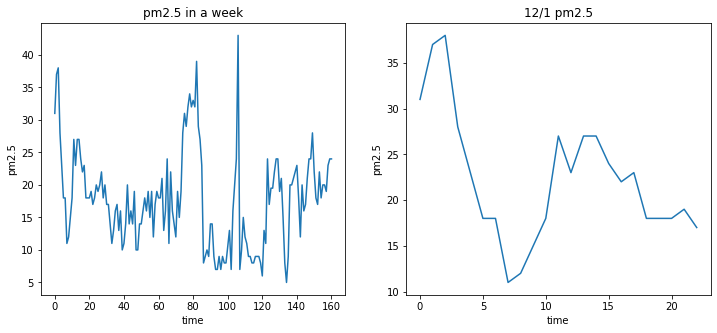

In [43]:
import matplotlib.pyplot as plt

Id = [i for i in range(0, 1458)]

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
#left plot / right plot
ax1.plot(Id[:23*7], train_y_pm25_1hr[:23*7]) #x軸的值, y軸的值
ax2.plot(Id[:23], train_y_pm25_1hr[:23])

ax1.set_title('pm2.5 in a week')
ax2.set_title('12/1 pm2.5')


for ax in fig.axes:
    ax.set_xlabel('time') #x軸標題
    ax.set_ylabel('pm2.5') #y軸標題


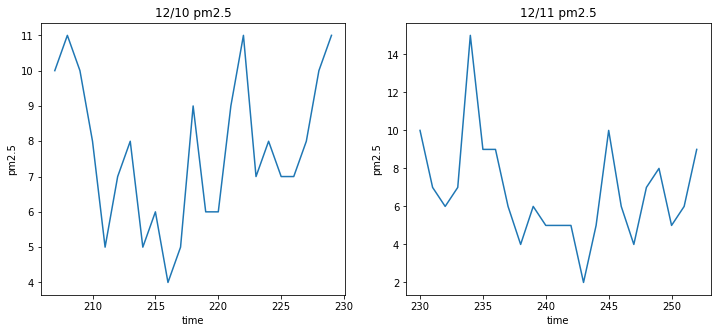

In [44]:
import matplotlib.pyplot as plt

Id = [i for i in range(0, 1458)]

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(Id[23*9:23*10], train_y_pm25_1hr[23*9:23*10])
ax2.plot(Id[23*10:23*11], train_y_pm25_1hr[23*10:23*11])
ax1.set_title('12/10 pm2.5')
ax2.set_title('12/11 pm2.5')

for ax in fig.axes:
    ax.set_xlabel('time')
    ax.set_ylabel('pm2.5')

*多元線性回歸模型*

    線性回歸是監督式學習的一種，在這個例子是以6天的資料預測未來某一天，寫成公式的話是

    預測pm2.5值 = A(第1小時pm2.5值) + B(第1小時pm2.5值) + ... +  N(第N小時pm2.5值)

*由於pm2.5的值是時間序列資料，可以用過去的資訊大致預測起伏，所以線性回歸效果較好(MAE平均絕對誤差較小)*

In [ ]:

print("MAE of Linear Regression - PM2.5 - 1HR : ",mean_absolute_error(test_y_pm25_1hr, LR_pred_pm25_1hr))
print("MAE of XGBoost - PM2.5 - 1HR : ",mean_absolute_error(test_y_pm25_1hr, XGB_pred_pm25_1hr))

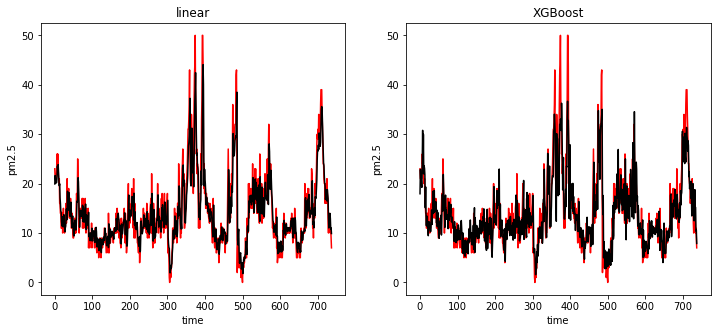

In [53]:
# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

#left plot / right plot
ax1.plot(Id[:738], test_y_pm25_1hr,'r', Id[:738], LR_pred_pm25_1hr,'k') 
#           (原始資料'r')x軸的值, y軸的值         / (預測資料'k')x軸的值, y軸的值
ax2.plot(Id[:738], test_y_pm25_1hr,'r', Id[:738], XGB_pred_pm25_1hr,'k')

ax1.set_title('linear') #黑色是預測值
ax2.set_title('XGBoost')


for ax in fig.axes:
    ax.set_xlabel('time') #x軸標題
    ax.set_ylabel('pm2.5') #y軸標題


*XGBoost模型*

    結合了Bagging與Boosting的優點
    
    與Bagging都是以Bootstrap的方式隨機抽取訓練樣本，但是樹之間是有相關性的
    
    同Boosting，會針對前面model的錯誤去學習，但是又能透過正規化去改善overfitting問題
    
此模型參數較多，因此要熟悉參數才能有好結果